In [0]:
# install and use tensorflow 2.0.0 instead of 1.15.0
!pip install tensorflow==2.0.0

In [0]:
# upload dataset from local file

from google.colab import files
uploaded = files.upload()

Saving Data Science Full.xlsx to Data Science Full.xlsx
Saving Data Science_20200214.xlsx to Data Science_20200214.xlsx


In [0]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed

In [0]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [0]:
# read dataset from file
df = pd.read_excel("./Data Science Full.xlsx", index_col="Date", parse_dates=True)
df = df.sort_index(ascending=True)
df = df[["Shipment","Revenue"]]
#df = df[["Shipment","Order","Backlog (current qtr)","Backlog (beyond qtr)","Pipeline","Revenue"]]

In [0]:
# normalize data into 0 to 1 using MinMaxScaler
scaler = MinMaxScaler()

df_transformed = scaler.fit_transform(df)

In [0]:
# choose a number of time steps
n_steps_in, n_steps_out = 120, 90

# split into samples
X, y = split_sequence(df_transformed, n_steps_in, n_steps_out)

n_features, n_epochs, n_neurons = df.columns.size, 50, 100
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

In [0]:
# define model
model = Sequential()
model.add(LSTM(n_neurons, activation='tanh', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(n_neurons, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X[:-1], y[:-1], epochs=n_epochs, verbose=1)
# demonstrate prediction

Train on 531 samples
Epoch 1/50
531/531 [==============================] - 6s 12ms/sample - loss: 0.1361
Epoch 2/50
531/531 [==============================] - 3s 6ms/sample - loss: 0.0933
Epoch 3/50
531/531 [==============================] - 3s 6ms/sample - loss: 0.0845
Epoch 4/50
531/531 [==============================] - 3s 6ms/sample - loss: 0.0824
Epoch 5/50
531/531 [==============================] - 3s 6ms/sample - loss: 0.0801
Epoch 6/50
531/531 [==============================] - 3s 6ms/sample - loss: 0.0760
Epoch 7/50
531/531 [==============================] - 3s 6ms/sample - loss: 0.0735
Epoch 8/50
531/531 [==============================] - 3s 6ms/sample - loss: 0.0723
Epoch 9/50
531/531 [==============================] - 3s 6ms/sample - loss: 0.0772
Epoch 10/50
531/531 [==============================] - 3s 6ms/sample - loss: 0.0659
Epoch 11/50
531/531 [==============================] - 3s 6ms/sample - loss: 0.0590
Epoch 12/50
531/531 [==============================] - 3s 6ms/s

In [0]:
# demonstrate prediction
x_pred = X[-1].reshape((1, X[-1].shape[0], n_features))

y_pred = model.predict(x_pred, verbose=1)

1/1 [==============================] - 1s 763ms/sample


In [0]:
y_pred = scaler.inverse_transform(y_pred[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


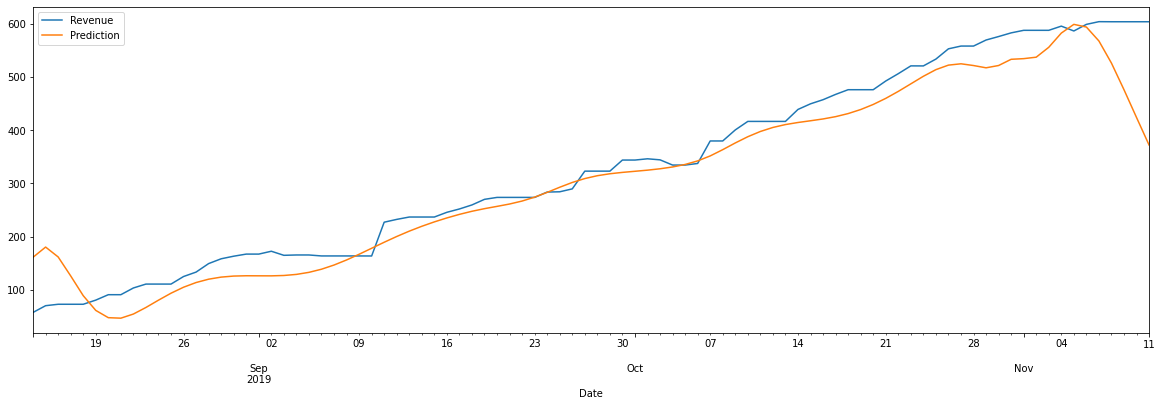

In [0]:
df_validate = df[-(n_steps_out):]
df_validate["Prediction"] = y_pred[:,1]
df_validate[["Revenue","Prediction"]].plot(figsize=(20,6))

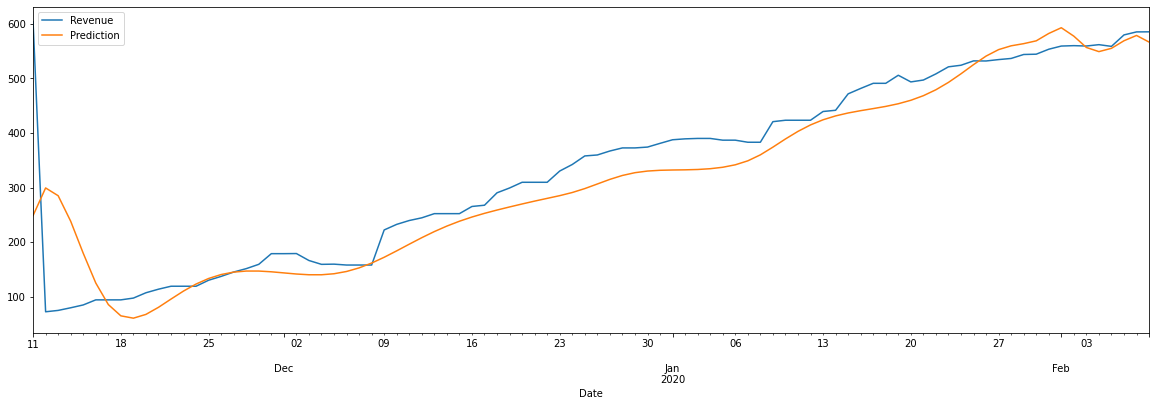

In [0]:
future_X = df_transformed[-(n_steps_in+1):-1].reshape((1,n_steps_in, n_features))

future_Y = model.predict(future_X)
future_Y = scaler.inverse_transform(future_Y[0])

df_future = pd.read_excel("./Data Science_20200214.xlsx", index_col="Date", parse_dates=True)
df_future = df_future.sort_index(ascending=True)
df_future = df_future[["Revenue"]]

df_future = df_future[-(n_steps_out):]
df_future["Prediction"] = future_Y[:,1]
df_future.plot(figsize=(20,6))

In [0]:
testScore = math.sqrt(mean_squared_error(df_future["Revenue"].iloc[3:], df_future["Prediction"].iloc[3:]))
print('Test Score: %.2f RMSE' % (testScore))

Final_Revenue_Error = 100*abs(df_future["Revenue"].iloc[3:].max() - df_future["Prediction"].iloc[3:].max())/ df_future["Revenue"].iloc[3:].max()
print('Final Revenue Error: %.2f%%' % (Final_Revenue_Error))

Test Score: 38.12 RMSE
Final Revenue Error: 1.28%
